 # Progetto Social Computing no.1

In [1]:
from __future__ import annotations
from dataclasses import InitVar, field, dataclass
import dataclasses
from typing import Any, Type, Iterable, TypeVar, Optional, TypedDict, Literal, cast
from collections.abc import Callable
from pathlib import Path
import os
import random
import json
import tweepy
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyvis.network import Network


 ## Init

In [2]:
rootUserName = "KevinRoitero"
# root user id will be used to deserialize data while offline
rootUserId = 3036907250
usersFileName = "users.json"
graph1FileName = "graph1.xml"
graph2FileName = "graph2.xml"

cwd = Path.cwd()
outputFolder = cwd / "users"
pvisFolder = cwd / "html"
graphsFolder = cwd / "graphs"

usersFile = outputFolder / usersFileName
graph1File = graphsFolder / graph1FileName
graph2File = graphsFolder / graph2FileName
secretsFile = cwd / "secrets.json"
skipGraphing = False
skipFetch = False
bearerToken = ""

outputFolder.mkdir(exist_ok=True, parents=True)
pvisFolder.mkdir(exist_ok=True, parents=True)
graphsFolder.mkdir(exist_ok=True, parents=True)

if graph1File.exists() and graph2File.exists():
    skipGraphing = True
    skipFetch = True
else:
    if secretsFile.exists():
        with secretsFile.open(encoding="utf-8") as f:
            secrets: dict[str, str] = json.load(f)
            f.close()
        bearerToken = secrets["bearerToken"]
    else:
        skipFetch = True

    if usersFile.exists():
        skipFetch = True
    else:
        print(f'Warning: "{usersFileName}" is missing. Data will be fetched.\n')
        if skipFetch == True:
            raise SystemExit('Error: "secrets.json" is missing\n')


 ## Data Models

In [3]:
@dataclass
class Tweet:
    tweet: InitVar[Optional[tweepy.Tweet]] = None
    serializedTweet: InitVar[Optional[Tweet.Serialized]] = None

    id: int = 0
    text: str = ""
    author: int = 0
    retweetCount: int = 0
    replyCount: int = 0
    likeCount: int = 0
    quoteCount: int = 0

    def __post_init__(
        self, tweet: Optional[tweepy.Tweet], serializedTweet: Optional[Tweet.Serialized]
    ):
        if tweet:
            self.id = tweet.id
            self.text = tweet.text
            self.author = tweet.author_id
            self.retweetCount = tweet.public_metrics["retweet_count"]
            self.replyCount = tweet.public_metrics["reply_count"]
            self.likeCount = tweet.public_metrics["like_count"]
            self.quoteCount = tweet.public_metrics["quote_count"]
        elif serializedTweet:
            self.__init__(**serializedTweet)

    def serialize(self):
        return cast(Tweet.Serialized, dataclasses.asdict(self))

    class Serialized(TypedDict):
        id: int
        text: str
        author: int
        retweetCount: int
        replyCount: int
        likeCount: int
        quoteCount: int


@dataclass
class User:
    user: InitVar[Optional[tweepy.User]] = None
    serializedUser: InitVar[Optional[tuple[str, User.Serialized]]] = None

    id: int = field(init=False)
    name: str = field(init=False)
    username: str = field(init=False)
    description: str = field(init=False)
    protected: bool = field(init=False)
    followersCount: int = field(init=False)
    followingCount: int = field(init=False)
    tweetCount: int = field(init=False)
    listedCount: int = field(init=False)
    followers: list[User] = field(init=False, default_factory=list)
    tweets: list[Tweet] = field(init=False, default_factory=list)

    def __post_init__(
        self,
        user: InitVar[Optional[tweepy.User]],
        serializedUser: InitVar[Optional[tuple[str, User.Serialized]]],
    ):
        if user:
            self.id: int = user.id
            self.name: str = user.name
            self.username: str = user.username
            self.description: str = user.description
            self.protected: bool = user.protected
            self.followersCount: int = user.public_metrics["followers_count"]
            self.followingCount: int = user.public_metrics["following_count"]
            self.tweetCount: int = user.public_metrics["tweet_count"]
            self.listedCount: int = user.public_metrics["listed_count"]
        elif serializedUser:
            self.id = int(serializedUser[0])
            for key in serializedUser[1]:
                if key == "tweets":
                    self.__setattr__(
                        "tweets",
                        [
                            Tweet(serializedTweet=serializedTweet)
                            for serializedTweet in serializedUser[1]["tweets"]
                        ],
                    )
                elif key != "followers":
                    self.__setattr__(key, serializedUser[1][key])

    def serialize(self):
        temp = self.__dict__.copy()
        del temp["id"]
        temp["followers"] = [user.id for user in self.followers]
        temp["tweets"] = [tweet.serialize() for tweet in self.tweets]
        return str(self.id), cast(User.Serialized, temp)

    # the serialization format chosen discourages user object duplication
    @staticmethod
    def deserializeOptimizedUsers(
        serializedUsers: dict[str, User.Serialized]
    ) -> dict[int, User]:
        users: dict[int, User] = {}

        for tuple in serializedUsers.items():
            users[int(tuple[0])] = User(serializedUser=tuple)
        for (id, serializedUser) in serializedUsers.items():
            users[int(id)].followers = [
                users[followerId] for followerId in serializedUser["followers"]
            ]
        return users

    class Serialized(TypedDict):
        name: str
        username: str
        description: str
        protected: bool
        followersCount: int
        followingCount: int
        tweetCount: int
        listedCount: int
        followers: list[int]
        tweets: list[Tweet.Serialized]


 ## Helpers

In [4]:
T = TypeVar("T")

# this is a helper function used to fix broken external dependencies typings
def listFromUnknown(type: Type[T], arg: Any) -> list[T]:
    if isinstance(arg, list):
        return cast(list[T], arg)
    elif arg:
        return cast(list[T], [arg])
    return []


# this is a helper function used to fix broken external dependencies typings
def unpackResponse(type: Type[T], response: tweepy.Response | Any) -> T:
    return cast(type, cast(tweepy.Response, response).data)


def fetchFollowers(client: tweepy.Client, user: User, limit: Optional[int] = None):
    if limit and limit <= 1000:
        user.followers = [
            User(u)
            for u in unpackResponse(
                Iterable[tweepy.User],
                client.get_users_followers(
                    user.id,
                    max_results=limit,
                    user_fields=["description", "public_metrics", "protected"],
                ),
            )
        ]
    else:
        user.followers = [
            User(u)
            for u in tweepy.Paginator(
                client.get_users_followers,
                user.id,
                max_results=1000,
                user_fields=["description", "public_metrics", "protected"],
                limit=-(limit // -1000) if limit else float("inf"),
            ).flatten(limit if limit else float("inf"))
        ]


drawOptionsNodes = {"node_color": "#07668C"}

drawOptionsEdges = {"edge_color": "#034007", "width": 1}

drawOptionsLabels = {"font_color": "#D9A648", "font_size": 7}


def draw(
    graph: nx.Graph,
    title: str,
    nodeSize: Callable[[int], int] = lambda n: 200,
    nodeColor: Callable[[int], str] = lambda n: drawOptionsNodes["node_color"],
):
    plt.style.use("dark_background")
    mpl.rcParams["figure.figsize"] = 10, 7
    nx.draw_networkx(
        graph,
        node_color=[nodeColor(node) for node in graph.nodes],
        node_size=[nodeSize(node) for node in graph.nodes],
        labels=dict(graph.nodes.data("username", default="")),  # type: ignore
        **drawOptionsEdges,
        **drawOptionsLabels
    )
    plt.title(title)
    plt.axis("off")
    plt.show()


# this draw functions tweaks the z-index to follow the measure values, at the cost of
# drawing speed
def drawWithMeasures(graph: nx.Graph, title: str, measures: dict[int, float]):
    plt.style.use("dark_background")
    mpl.rcParams["figure.figsize"] = 15, 7
    colorMap = mpl.cm.viridis  # type: ignore
    pos = nx.spring_layout(graph)
    for node in graph.nodes:
        nx.draw_networkx_nodes(
            graph,
            pos,
            node_size=200,
            cmap=colorMap,
            nodelist=[node],
            node_color=measures[node],  # type: ignore
            vmax=max(measures.values()),
            vmin=min(measures.values()),
        ).set_zorder(measures[node])
    edges = nx.draw_networkx_edges(graph, pos, **drawOptionsEdges)
    if isinstance(edges, mpl.collections.LineCollection):  # type: ignore
        edges.set_zorder(-1)  # type: ignore
    else:
        for edge in edges:
            edge.set_zorder(-1)
    nx.draw_networkx_labels(
        graph,
        pos,
        {
            node: username
            for (node, username) in graph.nodes.data("username", default="")  # type: ignore
            if measures[node] == max(measures.values())
        },
        font_color="#F24B4B",
        font_size=drawOptionsLabels["font_size"],
    )
    plt.colorbar(
        plt.cm.ScalarMappable(  # type: ignore
            norm=mpl.colors.Normalize(
                vmax=max(measures.values()),
                vmin=min(measures.values()),
            ),
            cmap=colorMap,
        ),
        ax=plt.gca(),
    )
    plt.title(title)
    plt.axis("off")
    plt.show()


def drawHtml(graph: nx.Graph, title: str):
    nt = Network(
        height="100%",
        width="100%",
        directed=graph.is_directed(),
        neighborhood_highlight=True,
        bgcolor="#262728",
        font_color="#ffffff",  # type: ignore
        heading=title,
    )
    nt.barnes_hut(damping=0.9)
    nt.from_nx(graph)
    for node in nt.nodes:
        node["label"] = node["username"] if "username" in node else ""

    os.chdir(pvisFolder)
    nt.save_graph(title.casefold() + ".html")
    os.chdir(cwd)


 ## Project 1

 ### Fetch

In [5]:
if not skipFetch:
    # You can authenticate as your app with just your bearer token
    client: tweepy.Client = tweepy.Client(
        bearer_token=bearerToken, wait_on_rate_limit=True
    )

    rootUser = User(
        unpackResponse(
            tweepy.User,
            tweepy.Client.get_user(
                client,
                username=rootUserName,
                user_fields=["description", "public_metrics", "protected"],
            ),
        )
    )

    fetchFollowers(client, rootUser)
    # test dataset
    # rootUser.followers = random.choices(rootUser.followers, k=5)

    for user in rootUser.followers:
        if not user.protected and user.followersCount >= 1:
            fetchFollowers(client, user, 1000)

            # This endpoint returns Tweets from the last seven days
            tweets = unpackResponse(
                Iterable[tweepy.Tweet],
                client.search_recent_tweets(
                    f"from:{user.id}",
                    max_results=100,
                    tweet_fields=["author_id", "public_metrics"],
                ),
            )
            if tweets:
                user.tweets = [Tweet(tweet=t) for t in tweets]


 ### Serialize Users

In [6]:
if not skipFetch:
    assert rootUser  # type: ignore
    serializedUsers: dict[str, User.Serialized] = dict(
        # the dictionary is populated starting from the leaves. Duplicate users will eventually be overwritten with
        # instances from the higher levels.
        reversed(
            # tree with duplicate users is flattened in level-order
            [
                u.serialize()
                for u in [rootUser]
                + rootUser.followers
                + [u for u in rootUser.followers for u in u.followers]
            ]
        )
    )

    with usersFile.open(mode="w", encoding="utf-8") as f:
        json.dump(serializedUsers, f, ensure_ascii=False, indent=4)
        f.close()


 ### Deserialize Users

In [9]:
if not skipGraphing:
    with usersFile.open(encoding="utf-8") as f:
        serializedUsers = cast(dict[str, User.Serialized], json.load(f))
        f.close()

    users = User.deserializeOptimizedUsers(serializedUsers)
    rootUser = users[rootUserId]


 ### Generate Graphs

In [10]:
if not skipGraphing:
    graph1 = nx.DiGraph()

    graphUsers = [rootUser] + rootUser.followers

    graph1.add_nodes_from(
        [
            (
                user.id,
                {
                    "username": user.username,
                    "description": user.description,
                    "followersCount": user.followersCount,
                },
            )
            for user in graphUsers
        ]
    )
    for B in graphUsers:
        for A in B.followers:
            if B.id in graph1 and A.id in graph1:
                graph1.add_edge(A.id, B.id)

    graph2 = nx.barabasi_albert_graph(
        graph1.number_of_nodes() * 2, 2, initial_graph=graph1.to_undirected()
    )

    nx.write_graphml(
        graph1, graph1File, encoding="utf-8", prettyprint=True, named_key_ids=True
    )
    nx.write_graphml(
        graph2, graph2File, encoding="utf-8", prettyprint=True, named_key_ids=True
    )

### Deserialize Graphs

In [11]:
graph1 = nx.read_graphml(graph1File, node_type=int)
graph2 = nx.read_graphml(graph2File, node_type=int)

### Print Graphs

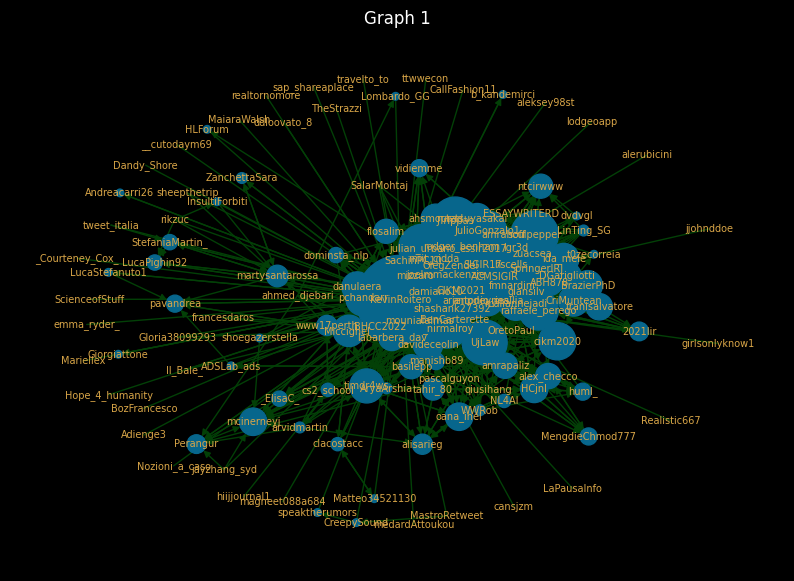

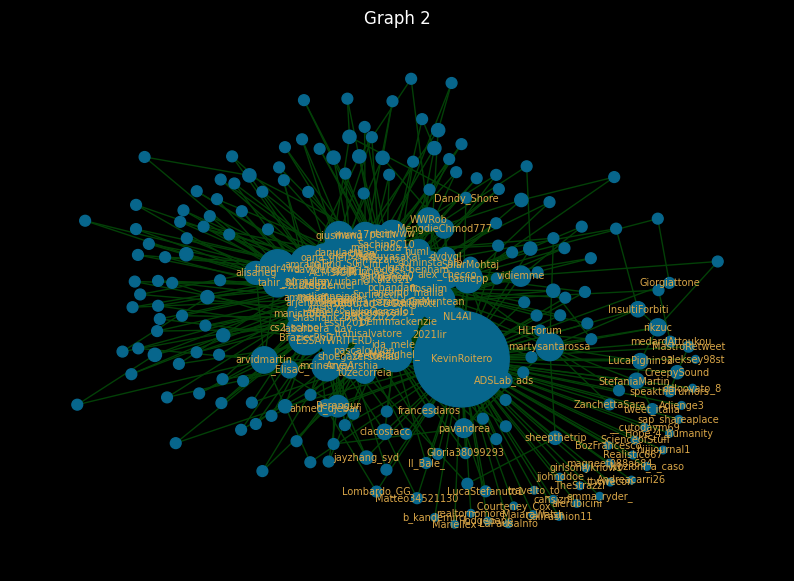

In [12]:
draw(graph1, "Graph 1", nodeSize=lambda node: 30 * cast(int, graph1.in_degree(node)))

draw(graph2, "Graph 2", nodeSize=lambda node: 30 * cast(int, graph2.degree(node)))


drawHtml(graph1, "Graph 1")
drawHtml(graph2, "Graph 2")


 ### Analysis

 #### Connected Components

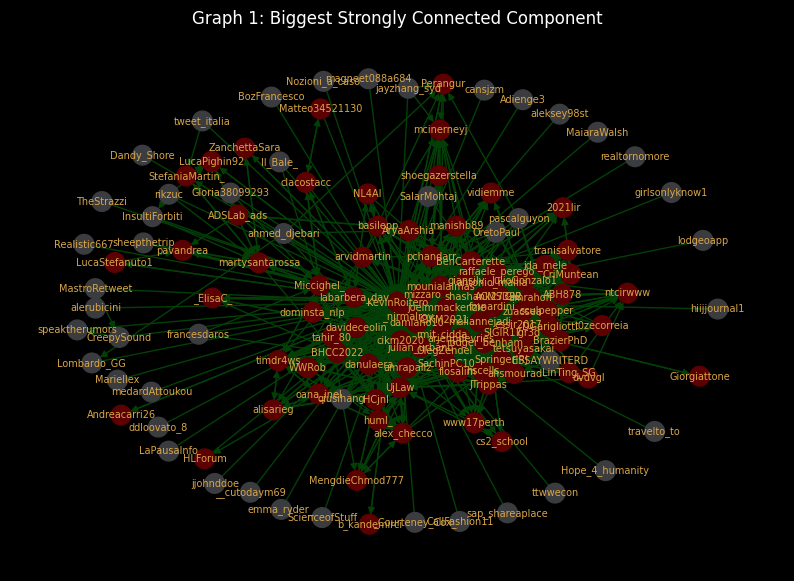

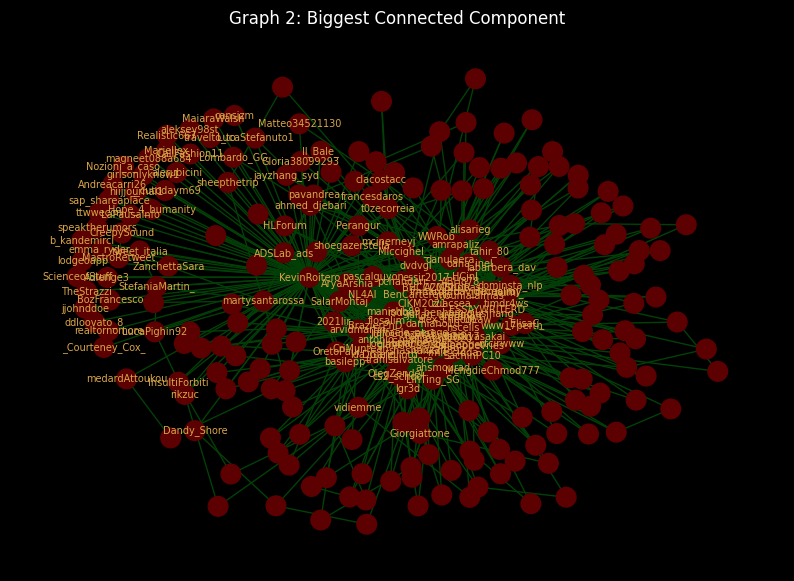

In [13]:
biggestSSCNodes = max(nx.strongly_connected_components(graph1), key=len)
biggestCCNodes = max(nx.connected_components(graph2), key=len)

biggestSSC: nx.Graph = nx.subgraph_view(
    graph1,
    filter_node=cast(
        Callable[[Any], Literal[True]],
        lambda node: True if node in biggestSSCNodes else False,
    ),
)

biggestCC: nx.Graph = nx.subgraph_view(
    graph2,
    filter_node=cast(
        Callable[[Any], Literal[True]],
        lambda node: True if node in biggestCCNodes else False,
    ),
)

draw(
    graph1,
    "Graph 1: Biggest Strongly Connected Component",
    nodeColor=lambda node: "#5C0002" if node in biggestSSC else "#3B3C40",
)

draw(
    graph2,
    "Graph 2: Biggest Connected Component",
    nodeColor=lambda node: "#5C0002" if node in biggestCC else "#3B3C40",
)


 #### Distances

In [14]:
print("Graph 1:")
eccentricities = nx.eccentricity(biggestSSC)
centers = [
    users[node].username
    for node in list(listFromUnknown(int, nx.center(biggestSSC, e=eccentricities)))
]
radius = nx.radius(biggestSSC, e=eccentricities)
averageShortestPathLength = nx.average_shortest_path_length(
    biggestSSC, method="floyd-warshall"
)
diameter = nx.diameter(biggestSSC, e=eccentricities)
print("\tcenters: ", centers)
print("\tradius: ", radius)
print("\taverage distance: ", averageShortestPathLength)
print("\tmaximum distance (diameter): ", diameter)

print("Graph 2:")
eccentricities = nx.eccentricity(biggestCC)
centers = [
    users[node].username if node in graph1 else node
    for node in listFromUnknown(int, nx.center(biggestCC, e=eccentricities))
]
radius = nx.radius(biggestCC, e=eccentricities)
averageShortestPathLength = nx.average_shortest_path_length(
    biggestCC, method="floyd-warshall"
)
diameter = nx.diameter(biggestCC, e=eccentricities)
print("\tcenters: ", centers)
print("\tradius: ", radius)
print("\taverage distance: ", averageShortestPathLength)
print("\tmaximum distance (diameter): ", diameter)


Graph 1:
	centers:  ['KevinRoitero', 'davideceolin', 'joelmmackenzie', 'labarbera_dav', 'BHCC2022', '_nirmalroy', 'timdr4ws', 'CIKM2021', 'rmit_cidda', 'damiano10', 'Miccighel_']
	radius:  3
	average distance:  2.0035750766087843
	maximum distance (diameter):  4
Graph 2:
	centers:  ['KevinRoitero']
	radius:  2
	average distance:  2.5361949207727372
	maximum distance (diameter):  4


#### Centrality

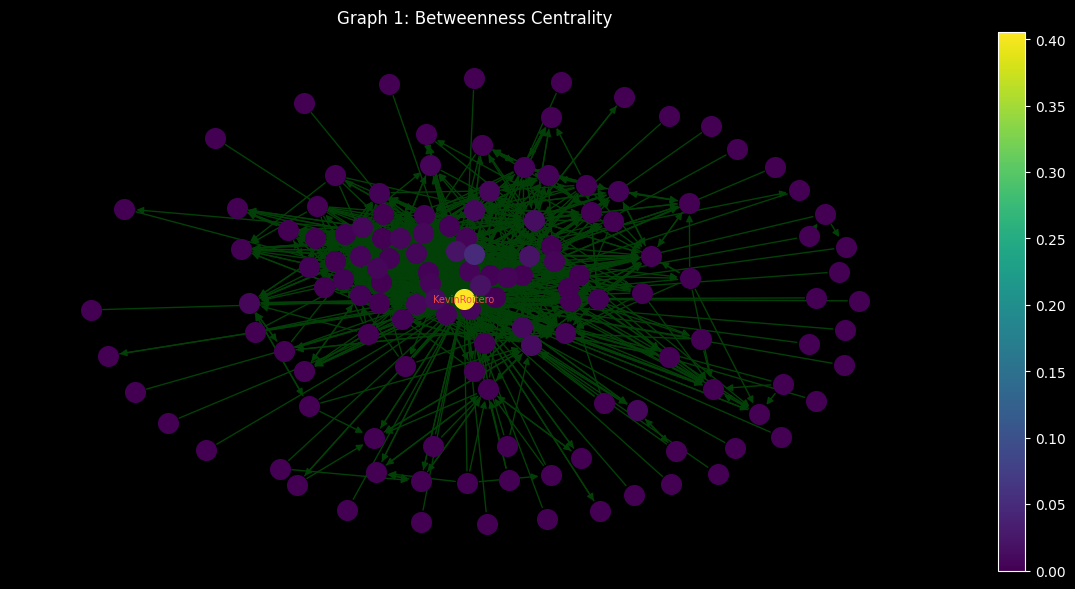

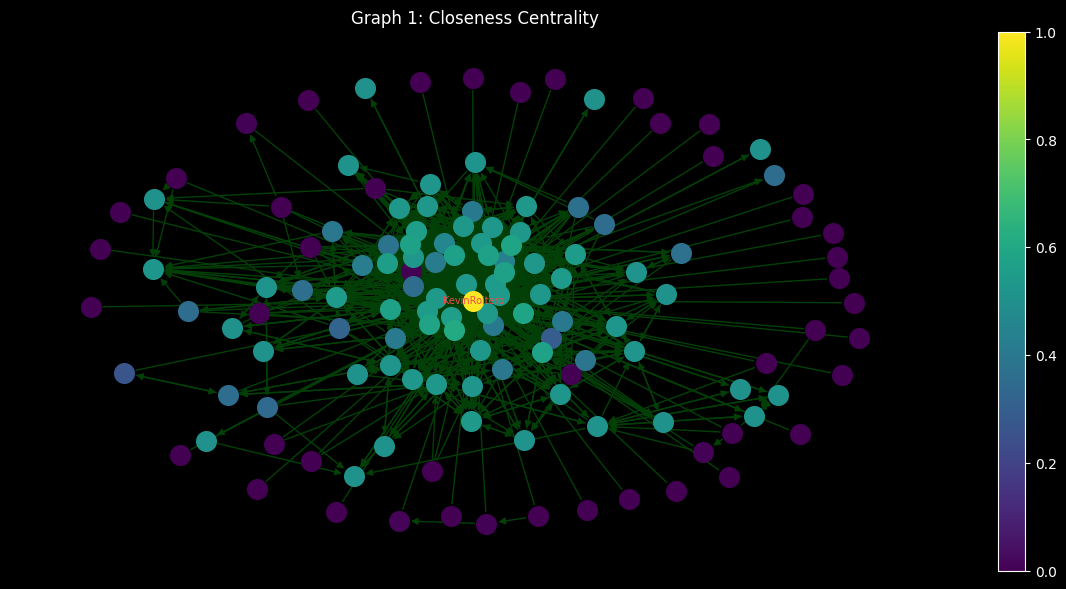

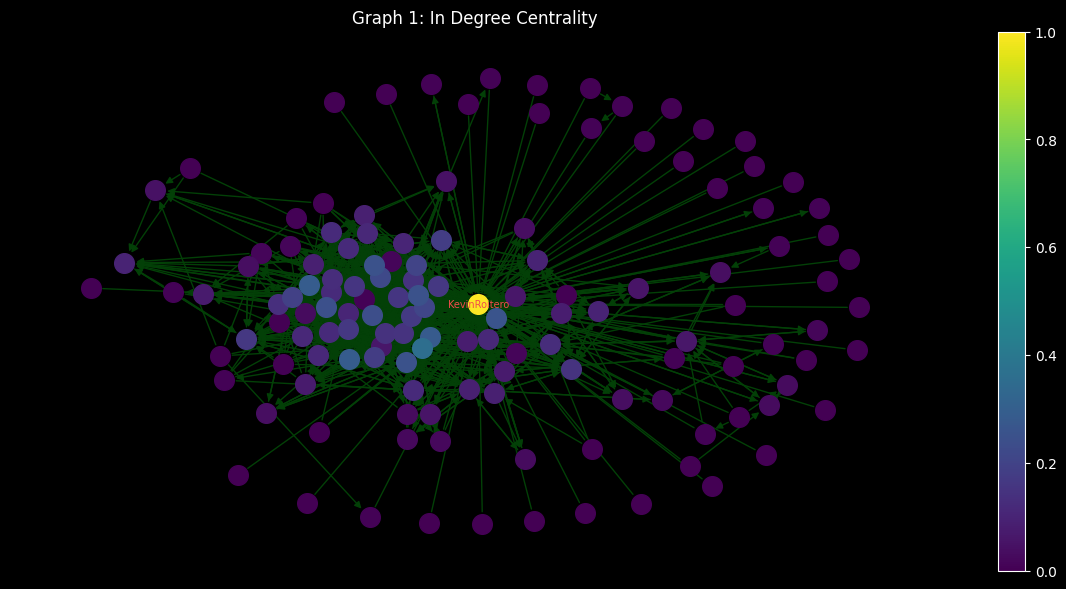

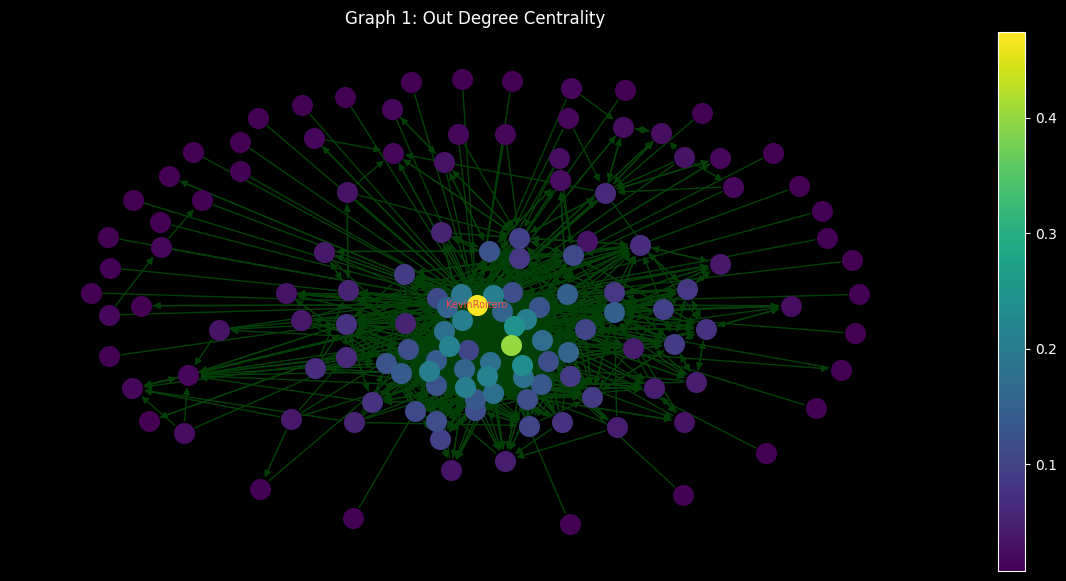

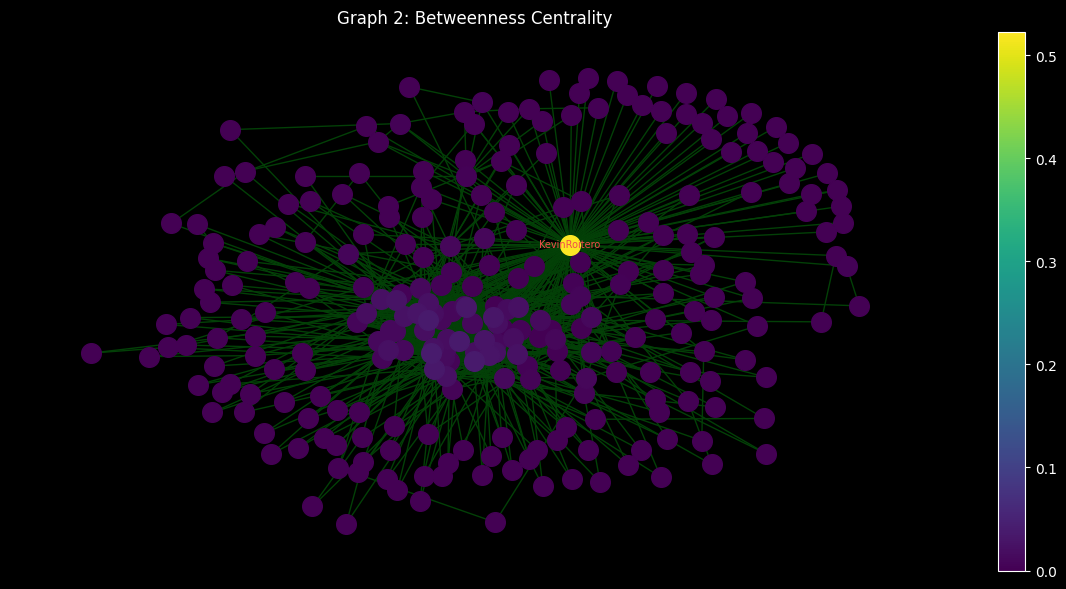

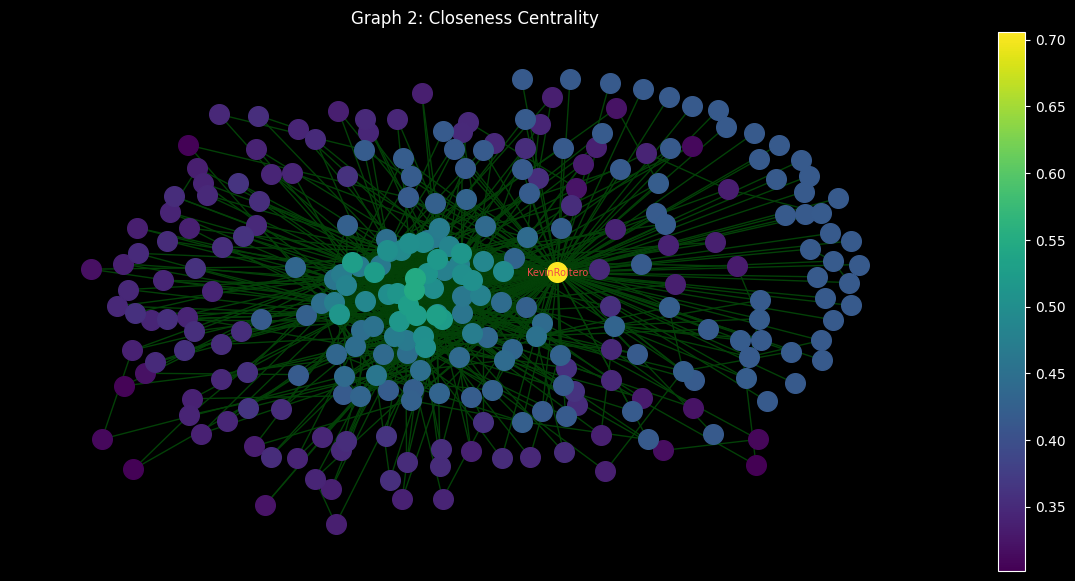

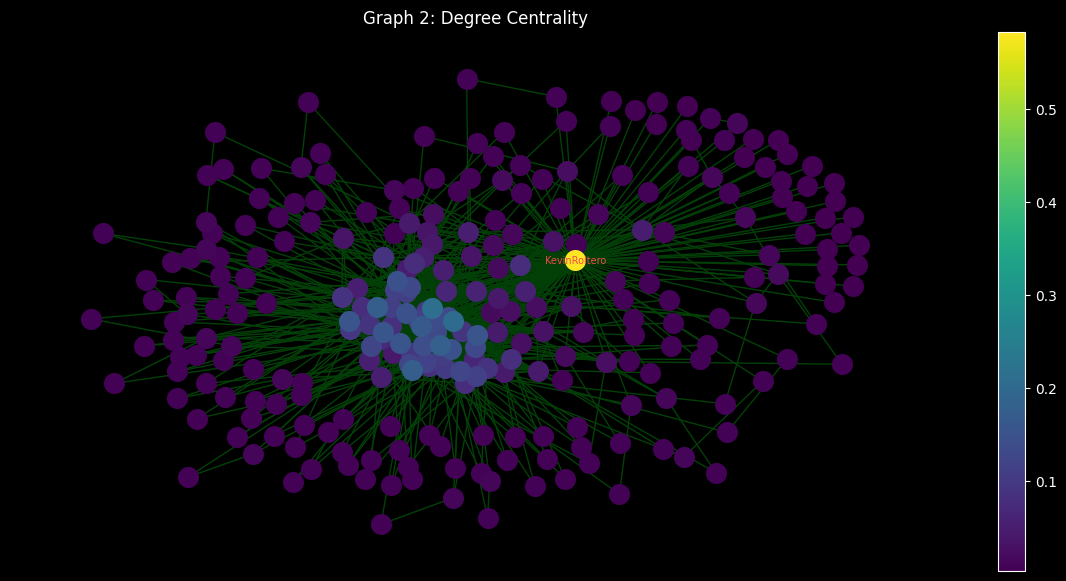

In [15]:
drawWithMeasures(
    graph1, "Graph 1: Betweenness Centrality", nx.betweenness_centrality(graph1)
)
drawWithMeasures(
    graph1, "Graph 1: Closeness Centrality", nx.closeness_centrality(graph1)
)
drawWithMeasures(
    graph1, "Graph 1: In Degree Centrality", nx.in_degree_centrality(graph1)
)
drawWithMeasures(
    graph1, "Graph 1: Out Degree Centrality", nx.out_degree_centrality(graph1)
)

drawWithMeasures(
    graph2, "Graph 2: Betweenness Centrality", nx.betweenness_centrality(graph2)
)
drawWithMeasures(
    graph2, "Graph 2: Closeness Centrality", nx.closeness_centrality(graph2)
)
drawWithMeasures(
    graph2,
    "Graph 2: Degree Centrality",
    cast(dict[int, float], nx.degree_centrality(graph2)),
)


#### Ranks

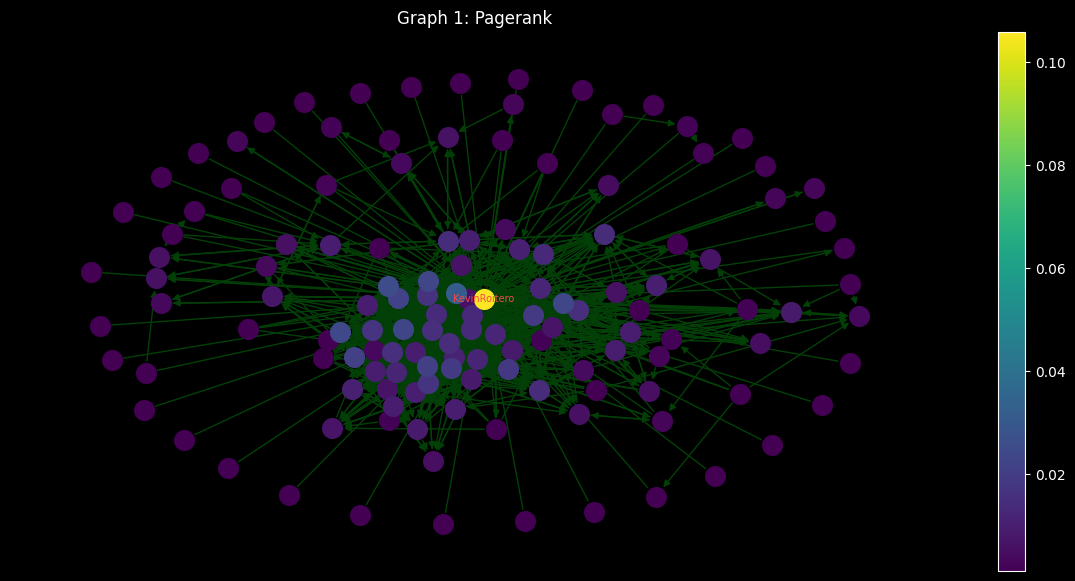

d:\Users\Nemo\python\social computing\Lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


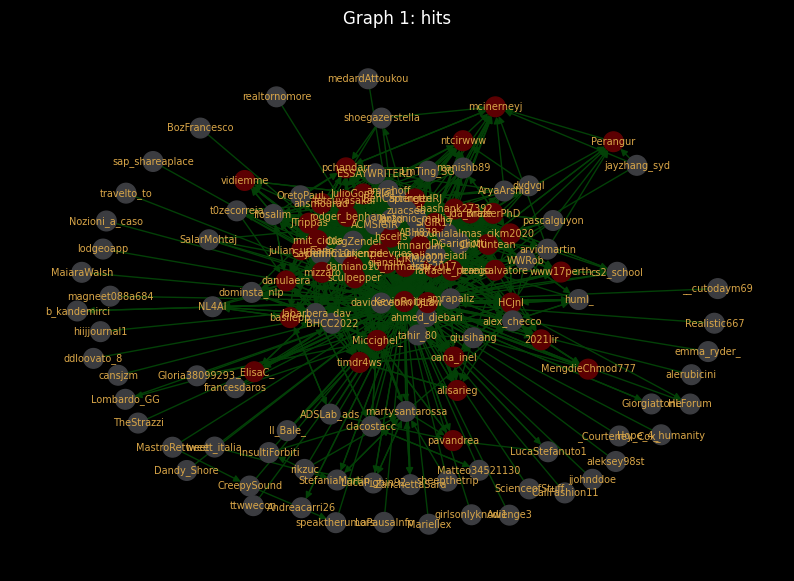

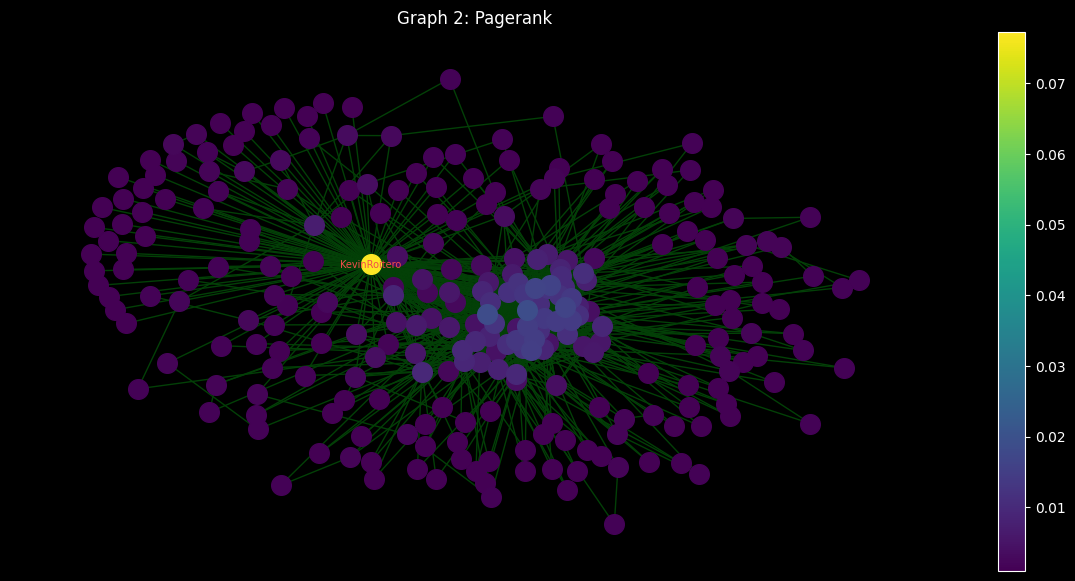

d:\Users\Nemo\python\social computing\Lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


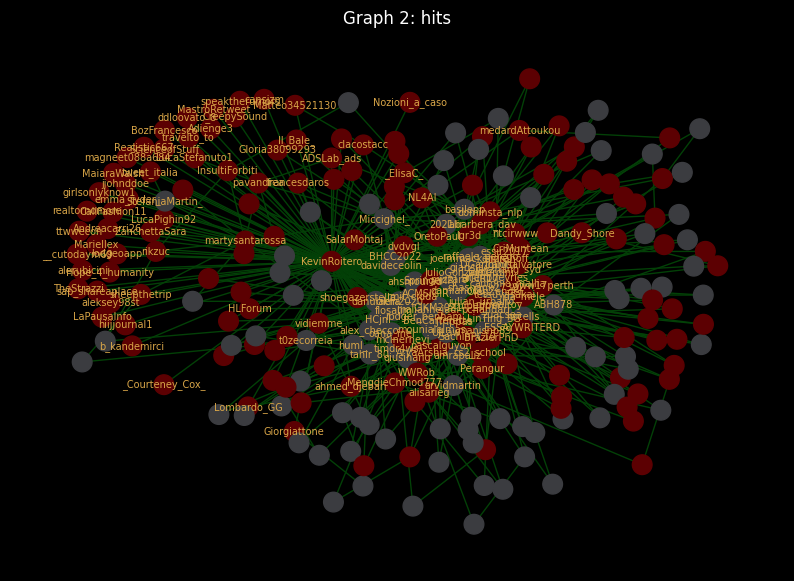

In [16]:
drawWithMeasures(graph1, "Graph 1: Pagerank", measures=nx.pagerank(graph1))
# dictionary tuple, (hubs, authorities)
hitsNodes = nx.hits(graph1)
draw(
    graph1,
    "Graph 1: hits",
    nodeColor=lambda node: "#5C0002"
    if hitsNodes[0][node] < hitsNodes[1][node]
    else "#3B3C40",
)
drawWithMeasures(graph2, "Graph 2: Pagerank", nx.pagerank(graph2))
hitsNodes = nx.hits(graph2)
draw(
    graph2,
    "Graph 2: hits",
    nodeColor=lambda node: "#5C0002"
    if hitsNodes[0][node] < hitsNodes[1][node]
    else "#3B3C40",
)


#### Omega and Sigma coefficients

In [ ]:
print("Graph 1:")
omegaCoefficient = nx.omega(graph1.to_undirected(as_view=True))
sigmaCoefficient = nx.sigma(graph1.to_undirected(as_view=True))
print("\tOmega coefficient: ", omegaCoefficient)
print("\tSigma coefficient: ", sigmaCoefficient)
print("Graph 2:")
omegaCoefficient = nx.omega(graph2)
sigmaCoefficient = nx.sigma(graph2)
print("\tOmega coefficient: ", omegaCoefficient)
print("\tSigma coefficient: ", sigmaCoefficient)


Graph 1:
	Omega coefficient:  0.09668690737025187
	Sigma coefficient:  1.2341497047273595
Graph 2:
	Omega coefficient:  0.14625850102099103
	Sigma coefficient:  1.3445190231516466
